# Benchmarking the Recovery of Known Drug Targets from L1000 CRISPR KO Data: Batch Version

In [8]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display, Markdown
import json
import requests
import time
from random import sample
from math import log2
from maayanlab_bioinformatics.dge import characteristic_direction, limma_voom
from maayanlab_bioinformatics.plotting import bridge_plot
import matplotlib.pyplot as plt
from os.path import exists

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [5]:
# Set KO gene
ko_gene = 'NR0B1'

# Set working directory
l1000_data_dir = '../L1000_data'

# Set parameters 
low_expression_threshold = 0.3

In [6]:
try: 
    expr_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv", sep='\t', index_col=0)
except: 
    l1000_data_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_data.tsv", sep='\t')

    l1000_data_list = []
    l1000_meta_list = []
    for row in l1000_data_df.itertuples(): 
        try:
            temp_df = pd.read_csv(row.persistent_id, sep='\t', index_col=0)
        except:
            print(f"Unable to access data from row {row.Index} at {row.persistent_id}")
            continue
        for col in temp_df.columns:
            l1000_meta_list.append([col] + l1000_data_df.loc[row.Index].tolist())
        l1000_data_list.append(temp_df)
    expr_df = pd.concat(l1000_data_list, axis=1)
expr_df.head()

,XPR032_A375.311_96H_X1_B38:N14,XPR032_A375.311_96H_X2_B38:N14,XPR032_A375.311_96H_X3_B38:N14,XPR032_A375.311_96H_X1_B38:P20,XPR032_A375.311_96H_X3_B38:P20,XPR032_A549.311_96H_X1_B38:N14,XPR032_A549.311_96H_X2_B38:N14,XPR032_A549.311_96H_X3_B38:N14,XPR032_A549.311_96H_X1_B38:P20,XPR032_A549.311_96H_X2_B38:P20,...,XPR032_U251MG.311_96H_X2_B38:N14,XPR032_U251MG.311_96H_X3_B38:N14,XPR032_U251MG.311_96H_X1_B38:P20,XPR032_U251MG.311_96H_X2_B38:P20,XPR032_U251MG.311_96H_X3_B38:P20,XPR032_YAPC.311_96H_X4.L2_B41:N14,XPR032_YAPC.311_96H_X5.L2_B41:N14,XPR032_YAPC.311_96H_X6.L2_B41:N14,XPR032_YAPC.311_96H_X4.L2_B41:P20,XPR032_YAPC.311_96H_X6.L2_B41:P20
symbol,,,,,,,,,,,,,,,,,,,,,
DDR1,5.255000,5.089600,5.427650,5.166525,5.239900,5.506400,5.4724,5.4069,5.7438,5.462400,...,5.63815,5.825700,6.23110,5.26800,5.916700,6.679475,6.938175,5.278950,7.19605,7.62890
PAX8,4.913075,5.132925,5.074600,4.669800,5.265650,4.016100,4.6268,4.2078,4.2377,4.310450,...,4.42210,4.625200,4.62415,4.53150,5.175500,4.408500,4.002800,4.260275,4.15570,3.35210
GUCA1A,5.193900,5.247600,4.621200,5.694850,5.050300,4.331350,4.3682,4.2829,4.3346,4.207350,...,4.98960,4.619000,4.86720,4.67185,4.904350,5.476200,5.236925,5.535125,5.46450,5.54065
EPHB3,5.674850,6.362250,6.259725,5.560650,6.506450,6.481000,6.4755,6.9908,6.4902,6.621600,...,7.15630,7.442451,7.25270,6.36430,7.246000,7.240800,7.576700,7.964250,7.88650,7.55025
ESRRA,7.840600,7.572600,7.368150,7.538750,7.622751,7.349851,7.5800,7.1017,7.1989,7.012701,...,6.22650,6.905600,6.75130,6.59240,7.017099,8.261250,8.548100,7.938550,8.24955,8.39360


In [9]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv"): 
    expr_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_fulldata.tsv' already exists!")

File at '../L1000_data/NR0B1_L1000_CRISPRKO_fulldata.tsv' already exists!


In [25]:
try: 
    meta_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv", sep='\t', index_col=0)
except:
    meta_df = pd.DataFrame(l1000_meta_list, columns=['id'] + l1000_data_df.columns.tolist()).set_index('id')
if 'batch' not in meta_df.columns:
    meta_df['batch'] = meta_df.index.map(lambda x: '_'.join(x.split('_')[:3]))
meta_df.head()

,tissue,disease,cell_line,pert_name,pert_time,pert_type,data_level,creation_time,persistent_id,pert_dose,batch
id,,,,,,,,,,,
XPR032_A375.311_96H_X1_B38:N14,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H
XPR032_A375.311_96H_X2_B38:N14,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H
XPR032_A375.311_96H_X3_B38:N14,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H
XPR032_A375.311_96H_X1_B38:P20,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H
XPR032_A375.311_96H_X3_B38:P20,skin of body,melanoma,A375.311,NR0B1,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR032_A375.311_96H


In [11]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv"): 
    meta_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_CRISPRKO_metadata.tsv' already exists!")

File at '../L1000_data/NR0B1_L1000_CRISPRKO_metadata.tsv' already exists!


In [76]:
batches = meta_df['batch'].unique()
len(batches)

9

## Load in Control Data

In [77]:
ctrl_data_df = pd.read_csv(f"{l1000_data_dir}/L1000_Controls.tsv", sep='\t')
ctrl_data_df = ctrl_data_df[ctrl_data_df['batch'].isin(batches)]
set(batches).difference(ctrl_data_df['batch'])

set()

In [14]:
ctrl_data_df.head()

,local_id,persistent_id,batch
10777,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_D10_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H
10778,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_E14_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H
10779,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_F21_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H
10780,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_G09_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H
10781,L1000_LINCS_DCIC_2021_XPR032_A375.311_96H_H16_...,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,XPR032_A375.311_96H


The following step extracts all control profiles from the same batch as the profiles of interest, and make take up to a few minutes to complete. 

In [15]:
try: 
    ctrl_expr_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv", sep='\t', index_col=0)
    ctrl_meta_df = pd.read_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv", sep='\t', index_col=0)
except:
    ctrl_data_list = []
    ctrl_meta_list = []
    for row in ctrl_data_df.itertuples():
        try: 
            temp_df = pd.read_csv(row.persistent_id, sep='\t', index_col=0)
        except:
            print(f"Unable to access data from row {row.Index} at {row.persistent_id}")
            continue
        for col in temp_df.columns: 
            ctrl_meta_list.append([col, row.batch])
        ctrl_data_list.append(temp_df)

    ctrl_expr_df = pd.concat(ctrl_data_list, axis=1)
    ctrl_meta_df = pd.DataFrame(ctrl_meta_list, columns=['id', 'batch']).set_index('id')

In [16]:
ctrl_expr_df.head()

,XPR032_A375.311_96H_X1_B38:D10,XPR032_A375.311_96H_X2_B38:D10,XPR032_A375.311_96H_X3_B38:D10,XPR032_A375.311_96H_X1_B38:E14,XPR032_A375.311_96H_X2_B38:E14,XPR032_A375.311_96H_X3_B38:E14,XPR032_A375.311_96H_X1_B38:F21,XPR032_A375.311_96H_X2_B38:F21,XPR032_A375.311_96H_X3_B38:F21,XPR032_A375.311_96H_X1_B38:G09,...,XPR032_YAPC.311_96H_X6.L2_B41:I09,XPR032_YAPC.311_96H_X4.L2_B41:K10,XPR032_YAPC.311_96H_X5.L2_B41:K10,XPR032_YAPC.311_96H_X6.L2_B41:K10,XPR032_YAPC.311_96H_X4.L2_B41:K20,XPR032_YAPC.311_96H_X5.L2_B41:K20,XPR032_YAPC.311_96H_X6.L2_B41:K20,XPR032_YAPC.311_96H_X4.L2_B41:P03,XPR032_YAPC.311_96H_X5.L2_B41:P03,XPR032_YAPC.311_96H_X6.L2_B41:P03
symbol,,,,,,,,,,,,,,,,,,,,,
NAT2,8.064151,9.469100,7.601850,8.033700,9.220400,8.24655,8.894925,8.72050,9.17865,8.68495,...,11.370251,10.716150,10.178425,11.328951,9.41990,11.02845,12.07100,11.243151,9.276251,9.758101
ADA,6.507850,6.016400,7.335375,6.141600,5.903550,6.85880,6.393500,6.74075,6.35025,5.83335,...,4.890375,5.205100,3.744300,5.539550,5.21020,4.89420,4.83905,4.656200,4.270800,5.249350
CDH2,4.857850,4.623050,5.011100,4.752725,4.761450,4.68530,5.200500,4.61915,4.61665,4.86035,...,4.382100,4.921475,4.550850,4.611150,4.30870,4.04470,4.89275,5.437850,4.703550,5.628650
AKT3,4.182400,1.805000,4.125150,3.381000,3.420925,4.00585,4.777750,4.22330,6.42225,2.92995,...,0.000000,1.254300,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
MED6,5.369700,6.277175,7.007350,6.533900,6.349325,6.65425,5.729750,6.16220,6.22880,6.02475,...,6.200250,6.642900,5.949200,7.149099,6.65355,6.47650,6.49045,7.638025,6.261400,7.256250


In [17]:
ctrl_meta_df.head()

,batch
id,
XPR032_A375.311_96H_X1_B38:D10,XPR032_A375.311_96H
XPR032_A375.311_96H_X2_B38:D10,XPR032_A375.311_96H
XPR032_A375.311_96H_X3_B38:D10,XPR032_A375.311_96H
XPR032_A375.311_96H_X1_B38:E14,XPR032_A375.311_96H
XPR032_A375.311_96H_X2_B38:E14,XPR032_A375.311_96H


In [18]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv"): 
    ctrl_expr_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_Controls_fulldata.tsv' already exists!")

File at '../L1000_data/NR0B1_L1000_Controls_fulldata.tsv' already exists!


In [19]:
if not exists(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv"): 
    ctrl_meta_df.to_csv(f"{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv", sep='\t', index=True)
else: 
    print(f"File at '{l1000_data_dir}/{ko_gene}_L1000_Controls_metadata.tsv' already exists!")

File at '../L1000_data/NR0B1_L1000_Controls_metadata.tsv' already exists!


## Normalize Data

### Combine data and remove duplicate genes

In [20]:
combined_df = pd.concat([
    expr_df.groupby(expr_df.index).mean(), 
    ctrl_expr_df.groupby(ctrl_expr_df.index).mean()
], axis=1)
combined_df.head()

,XPR032_A375.311_96H_X1_B38:N14,XPR032_A375.311_96H_X2_B38:N14,XPR032_A375.311_96H_X3_B38:N14,XPR032_A375.311_96H_X1_B38:P20,XPR032_A375.311_96H_X3_B38:P20,XPR032_A549.311_96H_X1_B38:N14,XPR032_A549.311_96H_X2_B38:N14,XPR032_A549.311_96H_X3_B38:N14,XPR032_A549.311_96H_X1_B38:P20,XPR032_A549.311_96H_X2_B38:P20,...,XPR032_YAPC.311_96H_X6.L2_B41:I09,XPR032_YAPC.311_96H_X4.L2_B41:K10,XPR032_YAPC.311_96H_X5.L2_B41:K10,XPR032_YAPC.311_96H_X6.L2_B41:K10,XPR032_YAPC.311_96H_X4.L2_B41:K20,XPR032_YAPC.311_96H_X5.L2_B41:K20,XPR032_YAPC.311_96H_X6.L2_B41:K20,XPR032_YAPC.311_96H_X4.L2_B41:P03,XPR032_YAPC.311_96H_X5.L2_B41:P03,XPR032_YAPC.311_96H_X6.L2_B41:P03
symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,5.042300,4.88865,4.503100,5.114400,4.19680,5.7100,5.7842,6.03365,6.00650,5.556000,...,11.807100,11.71735,12.049049,11.65135,12.454750,11.67805,11.785749,11.98595,12.474900,12.255699
A2M,8.136351,9.75640,7.550050,9.257950,8.29125,8.0900,8.1192,7.12570,6.50205,6.652599,...,7.871700,7.97915,7.558400,7.86500,7.667699,7.43105,8.419125,8.57765,7.610650,6.937225
A4GALT,5.682650,5.72150,5.574750,5.623775,5.77445,5.9049,5.6885,5.44520,5.58240,5.806400,...,5.152150,5.92100,5.048950,6.11105,5.527200,5.35310,5.177000,5.31725,5.868650,5.505100
A4GNT,5.345350,5.15115,5.101900,5.487600,4.99815,4.7636,4.7672,4.78310,4.81630,4.724250,...,10.035549,11.00025,10.085800,10.36765,10.302500,9.89095,9.880751,10.71460,10.327775,10.306700
AAAS,7.843300,8.01230,7.421226,7.221250,7.34165,7.4766,7.2301,7.06610,7.10430,7.214500,...,6.554150,6.45785,6.389650,6.15305,6.222600,6.66180,6.661350,6.67710,6.641350,6.521500


In [21]:
datasets = {
    'metadata': meta_df, 
    'ctrl_metadata': ctrl_meta_df,
    'rawdata': combined_df
}

## Compute Signatures: Batch Perturbations vs. Batch Controls

In [26]:
batch_profiles = {x: {'perts': [], 'ctrls': []} for x in batches}
for b in batches: 
    batch_profiles[b]['perts'] = meta_df[meta_df['batch'] == b].index.tolist()
    batch_profiles[b]['ctrls'] = ctrl_meta_df[ctrl_meta_df['batch'] == b].index.tolist()

In [27]:
batch_signatures = {'cd': {}, 'limma': {}, 'fc': {}}

### Characteristic Direction

In [28]:
# Function for computing signatures with characteristic direction
def cd_signature(ctrl_ids, case_ids, dataset, normalization):
  
    signature = characteristic_direction(
        dataset[normalization].loc[:, ctrl_ids], 
        dataset[normalization].loc[:, case_ids], 
        calculate_sig=True
    )
    signature = signature.sort_values("CD-coefficient", ascending=False)
    
    return signature

Note: the following step may take a few minutes to run.

In [29]:
for b in batches: 
    batch_signatures['cd'][b] = cd_signature(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        datasets, 
        'rawdata'
    )

### Limma

In [30]:
# Function for computing signatures
def limma(ctrl_ids, case_ids, dataset, normalization):
    
    signature = limma_voom.limma_voom_differential_expression(
        dataset[normalization].loc[:, ctrl_ids],
        dataset[normalization].loc[:, case_ids],
        filter_genes=False
    )
    signature = signature.sort_values("t", ascending=False)

    return signature

Note: the following step may take a few minutes to run.

In [31]:
for b in batches: 
    batch_signatures['limma'][b] = limma(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'], 
        datasets, 
        'rawdata'
    )

R[write to console]: Loading required package: R.oo

R[write to console]: Loading required package: R.methodsS3

R[write to console]: R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R[write to console]: R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.

R[write to console]: 
Attaching package: ‘R.oo’


R[write to console]: The following object is masked from ‘package:R.methodsS3’:

    throw


R[write to console]: The following objects are masked from ‘package:methods’:

    getClasses, getMethods


R[write to console]: The following objects are masked from ‘package:base’:

    attach, detach, load, save


R[write to console]: R.utils v2.10.1 (2020-08-26 22:50:31 UTC) successfully loaded. See ?R.utils for help.

R[write to console]: 
Attaching package: ‘R.utils’


R[write to console]: The following object is masked from ‘package:utils’:

    timestamp


R[write to console]: The following objects are masked from

### Fold Change

In [62]:
# Function for computing signatures with fold change
def logFC(ctrl_ids, case_ids, dataset, normalization):

    case_mean = dataset[normalization].loc[:, case_ids].mean(axis=1)
    ctrl_mean = dataset[normalization].loc[:, ctrl_ids].mean(axis=1)
    
    signature = case_mean / ctrl_mean

    signature = signature.apply(lambda x: log2(x+1)).rename('logFC')
    
    return pd.DataFrame(signature.sort_values(ascending=False))

In [63]:
for b in batches: 
    batch_signatures['fc'][b] = logFC(
        batch_profiles[b]['ctrls'], 
        batch_profiles[b]['perts'],
        datasets,
        'rawdata'
    )

## All signatures

In [34]:
batch_signatures['cd_all']= pd.concat([
    df[['CD-coefficient']].rename(columns={'CD-coefficient': b}) for (b, df) in batch_signatures['cd'].items()
], axis=1).sort_index()
batch_signatures['limma_all'] = pd.concat([
    df[['t']].rename(columns={'t': b}) for (b, df) in batch_signatures['limma'].items()
], axis=1).sort_index()
batch_signatures['fc_all'] = pd.concat([
    df.rename(b) for b, df in batch_signatures['fc'].items()
], axis=1).sort_index()

for k in batch_signatures.keys(): 
    if k.endswith('_all'): 
        method = k.split('_')[0].upper()
        display(Markdown(f"All {method} batch signatures"))
        display(batch_signatures[k])

All CD batch signatures

,XPR032_AGS.311_96H,XPR032_A549.311_96H,XPR032_BICR6.311_96H,XPR032_ES2.311_96H,XPR032_PC3.311B_96H,XPR032_U251MG.311_96H,XPR032_A375.311_96H,XPR032_HT29.311_96H,XPR032_YAPC.311_96H
symbol,,,,,,,,,
A1CF,-0.017783,-0.016047,-0.020645,-0.022145,-0.020482,-0.019187,-0.020061,-0.020211,-0.017267
A2M,0.005073,0.004325,-0.002482,0.001378,0.010943,0.009085,0.004170,0.003904,0.008592
A4GALT,0.001997,-0.001746,0.002162,-0.001375,0.000410,-0.000217,0.000460,0.000720,0.001741
A4GNT,-0.017431,-0.014972,-0.015936,-0.018799,-0.017925,-0.019558,-0.016629,-0.018877,-0.013562
AAAS,0.002736,0.003185,0.001409,0.004325,0.001021,0.003434,0.002492,0.002569,0.003237
...,...,...,...,...,...,...,...,...,...
ZXDB,-0.000282,-0.000234,0.000028,-0.002297,0.001384,-0.000324,-0.000004,-0.000076,-0.001289
ZXDC,-0.006142,-0.010458,-0.003045,-0.003486,-0.004996,-0.008848,-0.000090,0.002266,-0.002561
ZYX,0.012263,0.009031,0.010796,0.016862,0.014329,0.013464,0.014974,0.007596,0.009235


All LIMMA batch signatures

,XPR032_AGS.311_96H,XPR032_A549.311_96H,XPR032_BICR6.311_96H,XPR032_ES2.311_96H,XPR032_PC3.311B_96H,XPR032_U251MG.311_96H,XPR032_A375.311_96H,XPR032_HT29.311_96H,XPR032_YAPC.311_96H
A1CF,-31.401609,-50.202253,-92.215935,-57.170962,-40.826071,-40.648398,-43.490817,-52.801217,-32.479343
A2M,4.969393,4.644173,-7.136606,0.107135,10.578271,11.012444,5.799222,4.674300,7.700708
A4GALT,2.188914,-5.635605,10.049661,-2.815912,2.751041,0.346938,-1.500088,-0.499869,4.627847
A4GNT,-52.692189,-41.352716,-79.309756,-68.903881,-53.336398,-57.597987,-43.542568,-60.534034,-30.738910
AAAS,12.600847,14.252838,7.151148,11.757109,1.258617,15.252655,10.579879,7.990256,9.632633
...,...,...,...,...,...,...,...,...,...
ZXDB,-0.078946,-0.587111,3.251433,-2.533632,0.531741,-1.372360,3.515837,2.519761,-2.505127
ZXDC,-6.219017,-16.505548,-9.643654,-5.520325,-8.714572,-23.390602,-2.862318,1.014756,-6.854683
ZYX,22.489053,27.402711,35.119063,21.876607,20.948085,26.892091,22.315721,13.386875,10.346862
ZZEF1,-10.595280,-30.928752,-17.735101,-19.004267,-11.055636,-15.283503,-17.462598,-22.132080,-12.173054


All FC batch signatures

,XPR032_AGS.311_96H,XPR032_A549.311_96H,XPR032_BICR6.311_96H,XPR032_ES2.311_96H,XPR032_PC3.311B_96H,XPR032_U251MG.311_96H,XPR032_A375.311_96H,XPR032_HT29.311_96H,XPR032_YAPC.311_96H
symbol,,,,,,,,,
A1CF,-1.246737,-1.004192,-1.690429,-1.665790,-1.630342,-1.179333,-1.321012,-1.223911,-1.056337
A2M,0.278585,0.205393,-0.272091,0.000797,0.646290,0.502073,0.319819,0.240769,0.393296
A4GALT,0.068180,-0.146484,0.248284,-0.157615,0.139366,0.004167,-0.065231,-0.021841,0.184802
A4GNT,-1.126377,-1.144015,-1.158369,-1.293424,-1.172730,-1.301800,-1.089542,-1.185840,-0.852393
AAAS,0.240515,0.271056,0.096593,0.260816,0.036636,0.311805,0.278677,0.179783,0.199099
...,...,...,...,...,...,...,...,...,...
ZXDB,-0.003877,-0.017850,0.057785,-0.095970,0.019653,-0.036673,0.108741,0.053650,-0.078633
ZXDC,-0.307716,-0.705302,-0.272967,-0.435002,-0.509541,-0.574439,-0.265492,0.043187,-0.251703
ZYX,0.833233,0.651813,0.741641,1.234107,1.058885,0.964060,1.060643,0.631116,0.554679


## Enrichment Analysis Rankings

In [35]:
# Function to get Enrichr Results
def Enrichr_API(enrichr_gene_list, library_name, signame, method, direction):

    all_ranks = []
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(enrichr_gene_list)
    description = f'Dex benchmark {signame} {method} {direction} genes'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error uploading gene list')

    list_data = json.loads(response.text)
    time.sleep(0.5)
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    response = requests.get(
        ENRICHR_URL + f"?userListId={list_data['userListId']}&backgroundType={library_name}"
    )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    enrich_data = json.loads(response.text)
    results_df  = pd.DataFrame(enrich_data[library_name])
    all_ranks.append(list(results_df[0]))
    all_terms.append(list(results_df[1]))
    all_pvalues.append(list(results_df[2]))
    all_adjusted_pvalues.append(list(results_df[6]))

    res_dict = {
        'ranks': all_ranks, 
        'terms': all_terms, 
        'pvals': all_pvalues,
        'adjpvals': all_adjusted_pvalues, 
        'shortid': str(list_data['shortId'])
    }

    return res_dict

In [36]:
# Get gene lists to put into Enrichr
gene_lists = {}
for m in batch_signatures.keys():
    if 'all' in m:
        mname = m.split('_')[0]
        gene_lists[mname] = {'up': {}, 'down': {}, 'combined': {}}
        for sig in batch_signatures[m]: 
            gene_lists[mname]['up'][sig] = batch_signatures[m][sig].sort_values(ascending=False).index.tolist()[:250]
            gene_lists[mname]['down'][sig] = batch_signatures[m][sig].sort_values(ascending=True).index.tolist()[:250]
            gene_lists[mname]['combined'][sig] = gene_lists[mname]['up'][sig] + gene_lists[mname]['down'][sig]

In [37]:
# Get results
results = {}
for m in gene_lists.keys():
    results[m] = {'up': {}, 'down': {}, 'combined': {}}
    for d in gene_lists[m].keys():
        for sig in gene_lists[m][d].keys():
            results[m][d][sig]= Enrichr_API(
                gene_lists[m][d][sig], 'ChEA_2022', sig, m, d
            )

In [38]:
# Extract dexamethasone target rankings
# Initialize lists for storing target information
ranks = []

In [39]:
display(Markdown(f"## {ko_gene} Term Rankings"))

## NR0B1 Term Rankings

In [40]:
for m in results.keys(): 
    for d in results[m].keys():
        for sig in results[m][d].keys():
            for i in range(len(results[m][d][sig]['ranks'][0])): 
                if ko_gene in results[m][d][sig]['terms'][0][i]: 
                    ranks.append([
                        f"{sig}:{m}:{d}",
                        results[m][d][sig]['terms'][0][i], 
                        results[m][d][sig]['ranks'][0][i],
                        results[m][d][sig]['pvals'][0][i]
                    ])
full_df = pd.DataFrame(ranks, columns=['Gene_Set', 'Term', 'Rank', 'p-value'])
full_df['Method'] = full_df['Gene_Set'].apply(lambda x: x.split(':')[1])
full_df['Direction'] = full_df['Gene_Set'].apply(lambda x : x.split(':')[2])
full_df['Method_Direction'] = full_df.apply(lambda row: row['Method'] + ':' + row['Direction'], axis=1)

In [41]:
up_df = full_df[full_df['Direction']=='up']
down_df = full_df[full_df['Direction']=='down']
combined_df = full_df[full_df['Direction']=='combined']

In [42]:
display(Markdown(f"Mean rank of {ko_gene} terms from ChEA 2022 for up genes from each method."))
display(up_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown(f"Mean rank of {ko_gene} terms from ChEA 2022 for down genes from each method."))
display(down_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown(f"Mean rank of {ko_gene} terms from ChEA 2022 for combined up and down genes from each method."))
display(combined_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))

Mean rank of NR0B1 terms from ChEA 2022 for up genes from each method.

,Rank
Method,
cd,159.888889
fc,233.555556
limma,330.000000


Mean rank of NR0B1 terms from ChEA 2022 for down genes from each method.

,Rank
Method,
cd,562.333333
limma,562.666667
fc,595.111111


Mean rank of NR0B1 terms from ChEA 2022 for combined up and down genes from each method.

,Rank
Method,
cd,276.222222
fc,475.666667
limma,517.666667


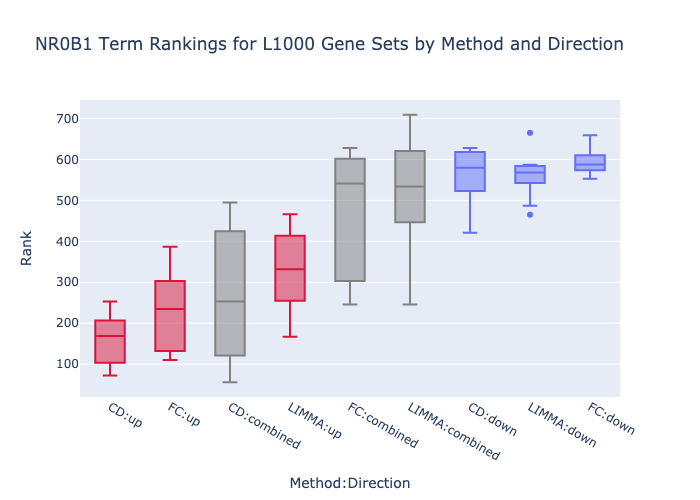

In [43]:
color_dict = {
    'up': 'crimson',
    'down': '#636EFA', 
    'combined': 'gray'
}

fig1 = go.Figure()
for gs in full_df.groupby('Method_Direction').mean().sort_values('Rank').index:
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Method_Direction']==gs]['Rank'].tolist(),
            name=gs.split(':')[0].upper() + ':' + gs.split(':')[1],
            marker_color=color_dict[gs.split(':')[1]]
        )
    )
fig1.update_layout(
    title_text=f"{ko_gene} Term Rankings for L1000 Gene Sets by Method and Direction",
    xaxis={
        'title': {'text': 'Method:Direction'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.show("png")

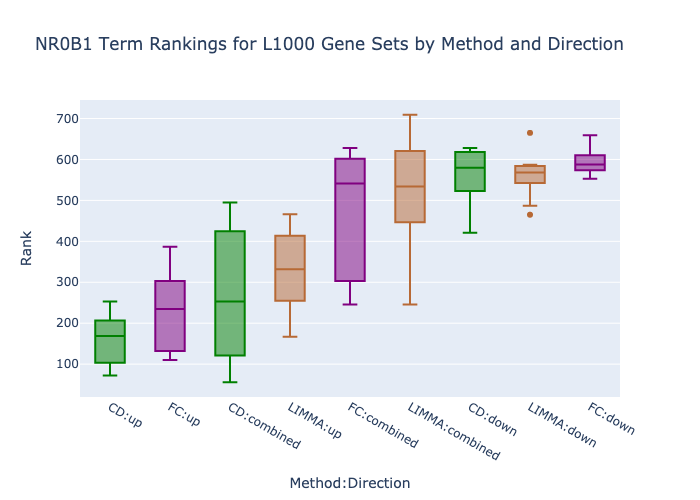

In [45]:
color_dict = {
    'cd': 'green',
    'limma': '#b76935', 
    'fc': 'purple'
}

fig1 = go.Figure()
for gs in full_df.groupby('Method_Direction').mean().sort_values('Rank').index:
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Method_Direction']==gs]['Rank'].tolist(),
            name=gs.split(':')[0].upper() + ':' + gs.split(':')[1],
            marker_color=color_dict[gs.split(':')[0]]
        )
    )
fig1.update_layout(
    title_text=f"{ko_gene} Term Rankings for L1000 Gene Sets by Method and Direction",
    xaxis={
        'title': {'text': 'Method:Direction'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.show("png")

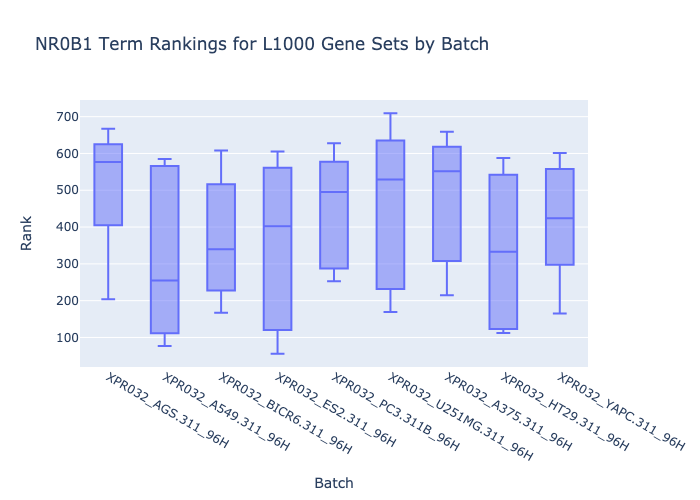

In [46]:
full_df['Batch'] = full_df['Gene_Set'].apply(lambda x: x.split(':')[0])
fig1 = go.Figure()
for gs in full_df['Batch'].unique():
    fig1.add_trace(
        go.Box(
            y=full_df[full_df['Batch']==gs]['Rank'].tolist(),
            name=gs,
            marker_color='#636EFA'
        )
    )
fig1.update_layout(
    title_text=f"{ko_gene} Term Rankings for L1000 Gene Sets by Batch",
    xaxis={
        'title': {'text': 'Batch'}, 
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.show("png")

## Bridge plots

In [48]:
def getEnrichrGeneSets(libname, termlist): 
    term_dict = {}
    liburl = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={libname}'
    response = requests.get(liburl)
    if not response.ok:
        raise Exception('Error fetching library from Enrichr')
    for term in termlist:
        geneset = response.json()[libname]['terms'][term].keys()
        term_dict[term] = geneset
    return term_dict

target_genesets = getEnrichrGeneSets('ChEA_2022', full_df['Term'].unique())

In [71]:
def methodBridgePlot(gsname, method, colname, abs_val=False): 
    geneset = target_genesets[gsname]
    y = []

    for k in batch_signatures[method].keys():
        if abs_val: 
            sig = batch_signatures[method][k][colname].apply(abs)
        else: 
            sig = batch_signatures[method][k][colname]
        select = pd.Series(
            [x.upper() in geneset for x in sig.sort_values(ascending=False).index.tolist()]
        )   
        x, y_temp = bridge_plot(select)
        y.append(y_temp)
    
    x = x/len(x)
    return x, np.mean(y, axis=0)

def randomBridgePlot(gsname): 
    all_x = []
    all_y = []

    for _ in range(10):
        rand_sig = sample(
            batch_signatures['cd_all'].index.tolist(), 
            batch_signatures['cd_all'].shape[0]
        )
        select = pd.Series([
            x.upper() in target_genesets[gsname] for x in rand_sig
        ])
        x, y = bridge_plot(select)
        x = x/len(x)
        all_x.append(x)
        all_y.append(y)

    return all_x, all_y

In [65]:
colnames = {
    'cd': 'CD-coefficient', 
    'limma': 't', 
    'fc': 'logFC'
}

In [72]:
def build_res(abs_val=False):
    res = {}
    for term in target_genesets.keys():
        res[term] = {'random': {'x': [], 'y': []}}
        rand_x, rand_y = randomBridgePlot(term)
        res[term]['random']['x'] += rand_x
        res[term]['random']['y'] += rand_y
        for method in batch_signatures.keys():
            if 'all' not in method:
                temp_x, temp_y = methodBridgePlot(term, method, colnames[method], abs_val=abs_val)
                if method in res[term].keys():
                    res[term][method]['x'].append(temp_x)
                    res[term][method]['y'].append(temp_y)
                else: 
                    res[term][method] = {'x': [temp_x], 'y': [temp_y]}
    return res

method_results = build_res(abs_val=False)
method_results_abs = build_res(abs_val=True)

In [73]:
def drawBridgePlot(abs_val=False):
    if abs_val:
        res = method_results_abs
    else: 
        res = method_results
    for term in res.keys():
        for sig in res[term].keys(): 
            term_x = np.mean(res[term][sig]['x'], axis=0)
            term_y = np.mean(res[term][sig]['y'], axis=0)
            if sig == 'random': 
                plt.plot(term_x, term_y, label=sig, color='gray')
            elif sig == 'CD': 
                plt.plot(term_x-(0.01*max(term_x)), term_y, label=sig)
            else:
                plt.plot(term_x, term_y, label=sig)

        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.legend(bbox_to_anchor=(1, 1))
        if abs_val:
            plt.title(f"{term.split(' ')[0]} Target Gene Rankings for Each Method (Abs Val)")
        else:
            plt.title(f"{term.split(' ')[0]} Target Gene Rankings for Each Method")
        plt.show()

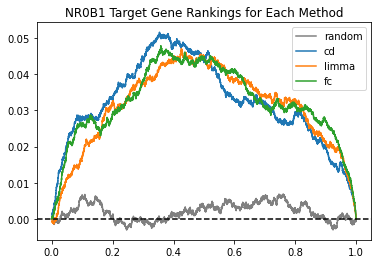

In [74]:
drawBridgePlot()